In [ ]:
# Mount Google Drive for dataset storage and checkpointing
from google.colab import drive
import os
import zipfile
import random

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings

# To suppress all warnings
warnings.filterwarnings('ignore')

In [ ]:
# Install dependencies
!pip install timm

# Import packages
import os
import time
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from datetime import datetime
import timm  # Vision Transformer models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [ ]:
import os
import zipfile

# Zip path and extract path
zip_path = '/content/drive/MyDrive/400mal_600ben/400mal_600ben_224.zip'
extract_path = '/content/400mal_600ben'

# 1. Unzip file
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

print("Unzip...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Finish Unzip!")

# 2. Print out structure of new path
print("\n File list & file:")
for root, dirs, files in os.walk(extract_path):
    print(f" {root}")
    for f in files[:5]:
        print(f"   - {f}")

Unzip...
Finish Unzip!

 File list & file:
 /content/400mal_600ben
 /content/400mal_600ben/400mal_600ben_224
   - ISIC_2766683.jpg
   - ISIC_8300377.jpg
   - ISIC_5365617.jpg
   - ISIC_2232442.jpg
   - ISIC_8195604.jpg
 /content/400mal_600ben/__MACOSX
 /content/400mal_600ben/__MACOSX/400mal_600ben_224
   - ._ISIC_9625875.jpg
   - ._ISIC_0517460.jpg


**1.DATA DECLARATION**

In [ ]:
# Parameter
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Path after unzip
CSV_PATH = '/content/drive/MyDrive/ISIC_2020_Training_GroundTruth.csv'
IMAGE_DIR = '/content/400mal_600ben/400mal_600ben_224'


Using device: cuda


**2. DATASET & DATALOADER – FULL**

In [ ]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import pandas as pd

# Define custom dataset for JPEG images
class JPEGDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx]["image_name"] + ".jpg")
        try:
            image = Image.open(img_name).convert("RGB")
            if self.transform:
                image = self.transform(image)
            label = self.dataframe.iloc[idx]["target"]
            return image, torch.tensor(label, dtype=torch.float32)
        except Exception as e:
            print(f"Error loading {img_name}: {str(e)}")
            dummy_img = torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE)
            return dummy_img, torch.tensor(0.0, dtype=torch.float32)

# Prepare training, validation, and test data loaders
def prepare_data_with_test(csv_path, image_dir, test_size=0.1, val_size=0.1):
    df = pd.read_csv(csv_path)
    existing = set(os.path.splitext(f)[0] for f in os.listdir(image_dir) if f.endswith(".jpg"))
    df = df[df["image_name"].isin(existing)]
    df = df[["image_name", "target"]].dropna()

    train_val_df, test_df = train_test_split(df, test_size=test_size, random_state=42, stratify=df["target"])
    val_frac = val_size / (1 - test_size)
    train_df, val_df = train_test_split(train_val_df, test_size=val_frac, random_state=42, stratify=train_val_df["target"])

    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    train_ds = JPEGDataset(train_df, image_dir, transform)
    val_ds   = JPEGDataset(val_df, image_dir, transform)
    test_ds  = JPEGDataset(test_df, image_dir, transform)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader


**3. MODEL TRAINING LOOP**

In [ ]:
import timm
import torch.nn as nn
import torch.optim as optim

# Initialize Vision Transformer model and optimizer
def setup_model():
    # Load pre-trained ViT backbone
    model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)

    # Create custom classification head
    classifier = nn.Sequential(
        nn.Linear(model.embed_dim, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 1)
    )

    # Combine backbone and classifier
    model = nn.Sequential(model, classifier).to(DEVICE)

    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, verbose=True)

    return model, criterion, optimizer, scheduler


In [ ]:
# Train model and save the best version based on validation loss
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader):
    best_val_loss = float('inf')

    for epoch in range(EPOCHS):
        print(f"\n Epoch {epoch+1}/{EPOCHS} - Training...")
        model.train()
        total_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)

        avg_train_loss = total_loss / len(train_loader.dataset)
        val_loss, val_metrics = evaluate_model(model, criterion, val_loader)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_metrics['accuracy']:.4f} | "
              f"AUC: {val_metrics['auc']:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), '/content/drive/MyDrive/vit_skin_best.pth')
            print(" Best model saved.")

**4. EVALUTATION**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import numpy as np

# Evaluate the model on a given DataLoader
def evaluate_model(model, criterion, loader):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader.dataset), {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, zero_division=0),
        'recall': recall_score(all_labels, all_preds, zero_division=0),
        'auc': roc_auc_score(all_labels, all_probs),
        'fpr': roc_curve(all_labels, all_probs)[0],
        'tpr': roc_curve(all_labels, all_probs)[1]
    }


**5. MAIN EXECUTION**

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


 Start training...

 Epoch 1/15 - Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15 | Train Loss: 0.6174 | Val Loss: 0.6026 | Val Acc: 0.5600 | AUC: 0.6850
 Best model saved.

 Epoch 2/15 - Training...
Epoch 2/15 | Train Loss: 0.5474 | Val Loss: 0.6046 | Val Acc: 0.6800 | AUC: 0.7933

 Epoch 3/15 - Training...
Epoch 3/15 | Train Loss: 0.5184 | Val Loss: 0.5839 | Val Acc: 0.7400 | AUC: 0.8333
 Best model saved.

 Epoch 4/15 - Training...
Epoch 4/15 | Train Loss: 0.5171 | Val Loss: 0.5749 | Val Acc: 0.6100 | AUC: 0.8296
 Best model saved.

 Epoch 5/15 - Training...
Epoch 5/15 | Train Loss: 0.5265 | Val Loss: 0.5833 | Val Acc: 0.7500 | AUC: 0.7917

 Epoch 6/15 - Training...
Epoch 6/15 | Train Loss: 0.4777 | Val Loss: 0.5292 | Val Acc: 0.7600 | AUC: 0.8317
 Best model saved.

 Epoch 7/15 - Training...
Epoch 7/15 | Train Loss: 0.4509 | Val Loss: 0.5559 | Val Acc: 0.6600 | AUC: 0.8292

 Epoch 8/15 - Training...
Epoch 8/15 | Train Loss: 0.4708 | Val Loss: 0.5194 | Val Acc: 0.7500 | AUC: 0.8079
 Best model saved.

 Epoch 9/15 - Training...
Epoch 9/15 | Train Loss: 

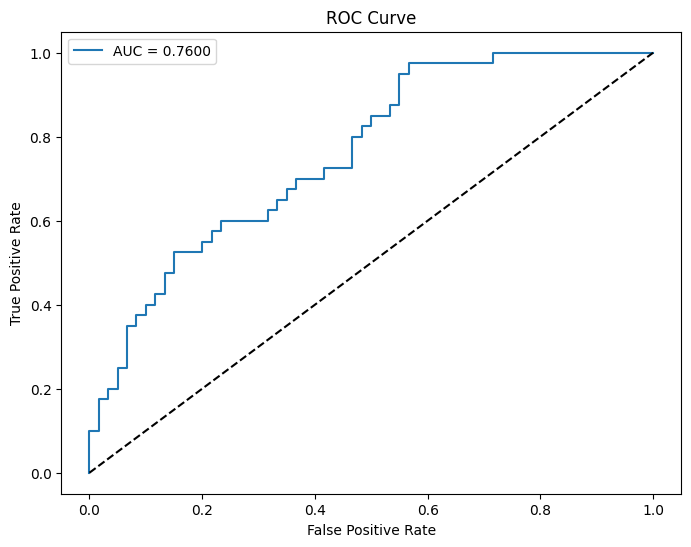

CPU times: user 1min 31s, sys: 5.57 s, total: 1min 36s
Wall time: 1min 55s


In [ ]:
%%time
# Prepare data loaders from CSV and image folder
train_loader, val_loader, test_loader = prepare_data_with_test(CSV_PATH, IMAGE_DIR)

# Initialize Vision Transformer model
model, criterion, optimizer, scheduler = setup_model()

# Start training
print("\n Start training...")
train_model(model, criterion, optimizer, scheduler, train_loader, val_loader)

# Load best model after training
print("\n Loading best model...")
model.load_state_dict(torch.load('/content/drive/MyDrive/vit_skin_best.pth'))

# Evaluate model on the test set
print("\n Evaluating on test set...")
test_loss, test_metrics = evaluate_model(model, criterion, test_loader)

# Print test results
print("\n Final Test Results")
print(f"Loss:     {test_loss:.4f}")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision:{test_metrics['precision']:.4f}")
print(f"Recall:   {test_metrics['recall']:.4f}")
print(f"AUC:      {test_metrics['auc']:.4f}")

# Plot and save ROC curve
import matplotlib.pyplot as plt

print("\n Plotting ROC Curve...")
plt.figure(figsize=(8, 6))
plt.plot(test_metrics['fpr'], test_metrics['tpr'], label=f'AUC = {test_metrics["auc"]:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
# plt.savefig('/content/drive/MyDrive/vit_roc_curve.png')
plt.show()


**6.TUNNING**

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 18.9 MB/s eta 0:00:00


In [ ]:
import optuna

def objective(trial):
    # hyperparameters
    lr = trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    weight_decay = trial.suggest_float("weight_decay", 0, 1e-4)

    # Setup model with current trial's hyperparams
    model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
    classifier = nn.Sequential(
        nn.Linear(model.embed_dim, 256),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(256, 1)
    )
    model = nn.Sequential(model, classifier).to(DEVICE)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Train only for 5 epochs to evaluate quickly
    for epoch in range(5):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate on validation set
    val_loss, val_metrics = evaluate_model(model, criterion, val_loader)

    # Return validation AUC as objective to maximize
    return val_metrics["auc"]


In [ ]:
study = optuna.create_study(direction="maximize")  # maximize AUC
study.optimize(objective, n_trials=10)

print("\nBest Trial:")
print(study.best_trial)

[I 2025-06-25 03:48:57,651] A new study created in memory with name: no-name-675e6f9b-f90f-49da-bbd9-ab1862cd4ef6
[I 2025-06-25 03:49:26,250] Trial 0 finished with value: 0.8479166666666667 and parameters: {'learning_rate': 4.7915711715564255e-05, 'dropout': 0.3499997238333231, 'weight_decay': 8.617029698532476e-05}. Best is trial 0 with value: 0.8479166666666667.
[I 2025-06-25 03:49:54,877] Trial 1 finished with value: 0.8316666666666667 and parameters: {'learning_rate': 7.333970897821733e-05, 'dropout': 0.1580799146727467, 'weight_decay': 7.965577002125312e-05}. Best is trial 0 with value: 0.8479166666666667.
[I 2025-06-25 03:50:23,450] Trial 2 finished with value: 0.8375 and parameters: {'learning_rate': 2.2520171263709304e-05, 'dropout': 0.2025782108463072, 'weight_decay': 6.504081261522709e-05}. Best is trial 0 with value: 0.8479166666666667.
[I 2025-06-25 03:50:52,049] Trial 3 finished with value: 0.7770833333333333 and parameters: {'learning_rate': 6.23542031245196e-05, 'dropout


Best Trial:
FrozenTrial(number=4, state=1, values=[0.87], datetime_start=datetime.datetime(2025, 6, 25, 3, 50, 52, 50389), datetime_complete=datetime.datetime(2025, 6, 25, 3, 51, 20, 636817), params={'learning_rate': 1.830653447849522e-05, 'dropout': 0.12372579910981632, 'weight_decay': 6.929956707408269e-06}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.0005, log=True, low=1e-05, step=None), 'dropout': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'weight_decay': FloatDistribution(high=0.0001, log=False, low=0.0, step=None)}, trial_id=4, value=None)


**7.RETRAIN WITH BEST PARAM**


 Retraining Vision Transformer with best Optuna parameters...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15 | Train Loss: 0.5392 | Val AUC: 0.8538
 Saved new best model.
Epoch 2/15 | Train Loss: 0.3823 | Val AUC: 0.8542
 Saved new best model.
Epoch 3/15 | Train Loss: 0.2345 | Val AUC: 0.8588
 Saved new best model.
Epoch 4/15 | Train Loss: 0.1291 | Val AUC: 0.8483
Epoch 5/15 | Train Loss: 0.0510 | Val AUC: 0.8629
 Saved new best model.
Epoch 6/15 | Train Loss: 0.0234 | Val AUC: 0.8758
 Saved new best model.
Epoch 7/15 | Train Loss: 0.0157 | Val AUC: 0.8492
Epoch 8/15 | Train Loss: 0.0124 | Val AUC: 0.8612
Epoch 9/15 | Train Loss: 0.0019 | Val AUC: 0.8621
Epoch 10/15 | Train Loss: 0.0010 | Val AUC: 0.8629
Epoch 11/15 | Train Loss: 0.0008 | Val AUC: 0.8621
Epoch 12/15 | Train Loss: 0.0007 | Val AUC: 0.8617
Epoch 13/15 | Train Loss: 0.0006 | Val AUC: 0.8608
Epoch 14/15 | Train Loss: 0.0005 | Val AUC: 0.8612
Epoch 15/15 | Train Loss: 0.0005 | Val AUC: 0.8617

 Loading best model...

 Evaluating on test set...

 Final Test Results
Loss:     0.9981
Accuracy: 0.7500
Precision:0.6744
Recal

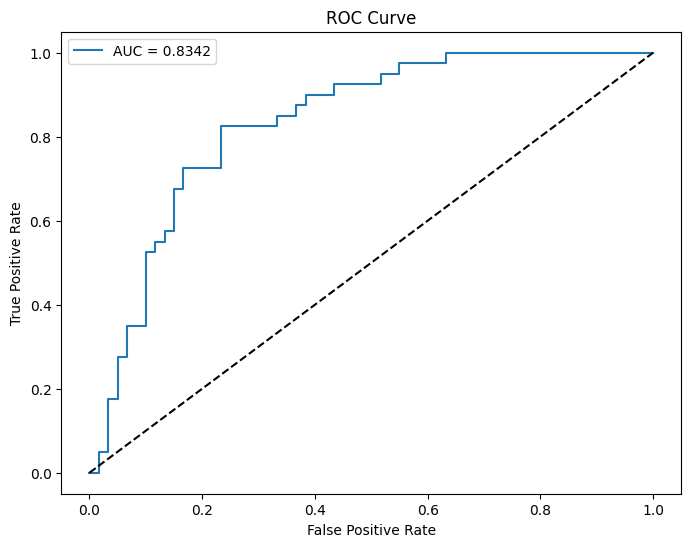

CPU times: user 1min 30s, sys: 5.02 s, total: 1min 35s
Wall time: 1min 44s


In [ ]:
%%time

# ===== Get best hyperparameters from Optuna =====
best_params = study.best_trial.params

# ===== Innitilize ViT with best param =====
from timm import create_model
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

def setup_vit_model_with_custom_params(lr, dropout, weight_decay):
    model = create_model(
        'vit_base_patch16_224',
        pretrained=True,
        num_classes=1,
        drop_rate=dropout
    )
    model.to(DEVICE)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    return model, criterion, optimizer, scheduler

# ===== prep data =====
train_loader, val_loader, test_loader = prepare_data_with_test(CSV_PATH, IMAGE_DIR)

# ===== innitialize with best params =====
model, criterion, optimizer, scheduler = setup_vit_model_with_custom_params(
    lr=best_params['learning_rate'],
    dropout=best_params['dropout'],
    weight_decay=best_params['weight_decay']
)

# ===== train with validation and save best model =====
import copy
import numpy as np

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=EPOCHS):
    best_auc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)

        avg_train_loss = total_loss / len(train_loader.dataset)

        # Validation
        val_loss, val_metrics = evaluate_model(model, criterion, val_loader)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val AUC: {val_metrics['auc']:.4f}")

        # Save best model
        if val_metrics['auc'] > best_auc:
            best_auc = val_metrics['auc']
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, '/content/drive/MyDrive/vit_skin_best.pth')
            print(" Saved new best model.")

    model.load_state_dict(best_model_wts)
    return model

# ===== Start retrain =====
print("\n Retraining Vision Transformer with best Optuna parameters...")
model = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader)

# ===== Get best model =====
print("\n Loading best model...")
model.load_state_dict(torch.load('/content/drive/MyDrive/vit_skin_best.pth'))

# ===== Evaluate test set =====
print("\n Evaluating on test set...")
test_loss, test_metrics = evaluate_model(model, criterion, test_loader)

# ===== Print result =====
print("\n Final Test Results")
print(f"Loss:     {test_loss:.4f}")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision:{test_metrics['precision']:.4f}")
print(f"Recall:   {test_metrics['recall']:.4f}")
print(f"AUC:      {test_metrics['auc']:.4f}")

# =====  ROC Curve =====
import matplotlib.pyplot as plt

print("\n Plotting ROC Curve...")
plt.figure(figsize=(8, 6))
plt.plot(test_metrics['fpr'], test_metrics['tpr'], label=f'AUC = {test_metrics["auc"]:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [ ]:
# Evaluate on test set
test_loss, test_metrics = evaluate_model(model, criterion, test_loader)

# Print result
print("\n Final Test Results with Best Hyperparameters")
print(f"Loss:     {test_loss:.4f}")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision:{test_metrics['precision']:.4f}")
print(f"Recall:   {test_metrics['recall']:.4f}")
print(f"AUC:      {test_metrics['auc']:.4f}")


 Final Test Results with Best Hyperparameters
Loss:     0.9981
Accuracy: 0.7500
Precision:0.6744
Recall:   0.7250
AUC:      0.8342
